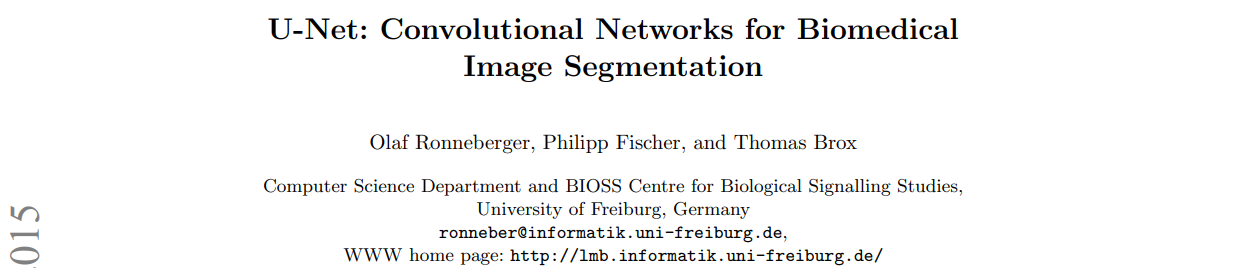

In [1]:
%pwd

'C:\\Users\\ebdl\\Project 폴더\\딥러닝모델들'

# Import

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

# Oxford-IIIT Pet Dataset을 다운로드합니다

In [3]:
dataset, info = tfds.load('oxford_iiit_pet', with_info=True)
print(dataset.keys())
print(info)

dict_keys(['train', 'test'])
tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='C:\\Users\\ebdl\\tensorflow_datasets\\oxford_iiit_pet\\3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'la

데이터는 train, test가 나누어져서 제공되고
- *file_name*
- **image**
- *label*
- **segmentation_mask**
- *species* <br>

가 제공되지만 image와 segmentation만 사용합니다.

In [4]:
def random_flip(input_image, input_mask):
    ''' 이미지와 마스크 random flip'''
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    
    return input_image, input_mask
 
def normalize(input_image, input_mask):
    '''
    이미지 픽셀의 값을 [0,1] 사이로 정규화
    범위가 [0,2]가 되도록 마스크 레이블에서 1을 뺀다
    '''
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask
 
def load_image_train(datapoint):
    ''' 훈련데이터 resize, normalize 와 flips  '''
    input_image = tf.image.resize(datapoint['image'], (128, 128), method='nearest')
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
    
    input_image, input_mask = random_flip(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
 
    return input_image, input_mask
 
def load_image_test(datapoint):
    ''' 테스트데이터 resize 및 normalize'''
    input_image = tf.image.resize(datapoint['image'], (128, 128), method='nearest')
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
    
    input_image, input_mask = normalize(input_image, input_mask)
 
    return input_image, input_mask

**정의한 함수로 전처리를 진행합니다**

In [5]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [6]:
train, test

(<ParallelMapDataset shapes: ((128, 128, 3), (128, 128, 1)), types: (tf.float32, tf.uint8)>,
 <MapDataset shapes: ((128, 128, 3), (128, 128, 1)), types: (tf.float32, tf.uint8)>)

In [7]:
''' 배치사이즈 64인 train,test dataset 생성'''
BATCH_SIZE = 64
BUFFER_SIZE = 1000
 
# train set을 배치단위로 나누어 shuffle
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
 
# 데이터 처리 속도 향상을 위해 prefetch
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
 
# test 셋도 배치단위로 나누어준다
test_dataset = test.batch(BATCH_SIZE)

데이터 샘플 확인

In [8]:
'''시각화 함수'''
# 마스크의 class들
class_names = ['pet', 'background', 'outline']
 
def display_with_metrics(display_list, iou_list, dice_score_list):
    ''' 이미지/마스크 목록을 표시하고 IoU 및 Dice Score 목록을 오버레이합니다. '''
    metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list))]
    metrics_by_id.sort(key=lambda tup: tup[1], reverse=True) # sort in place
 
    display_string_list = [f"{class_names[idx]}: IoU: {iou} Dice Score: {dice_score}" for idx, iou, dice_score in metrics_by_id]
    display_string = "\n\n".join(display_string_list)
 
    display(display_list, ["Image", "Predicted Mask", "True Mask"], display_string=display_string)
 
def display(display_list, titles=[], display_string=None):
    ''' 이미지/마스크 목록 표시'''
    plt.figure(figsize=(15,15))
 
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(titles[i])
        plt.xticks([])
        plt.yticks([])
        if display_string and i == 1:
            plt.xlabel(display_string, fontsize=12)
        img_arr = tf.keras.preprocessing.image.array_to_img(display_list[i])
        plt.imshow(img_arr)
    
    plt.show()

# 이미지와 mask를 모두 보여준다
def show_image_from_dataset(dataset):
    for image, mask in dataset.take(1):
        sample_image, sample_mask = image, mask
    display([sample_image, sample_mask], titles=['Image', 'True Maks'])

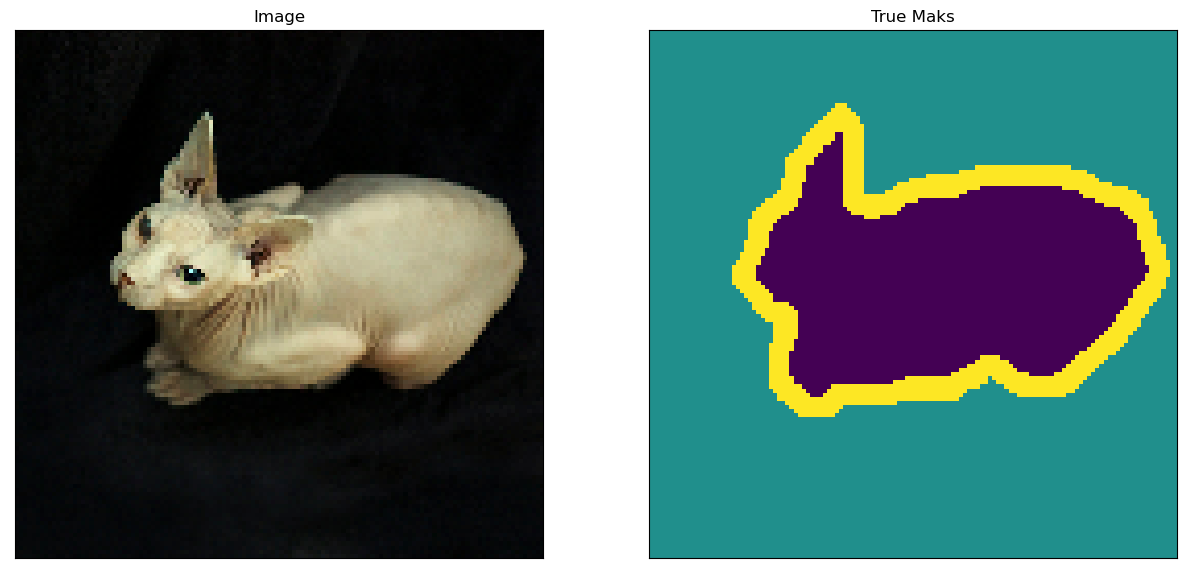

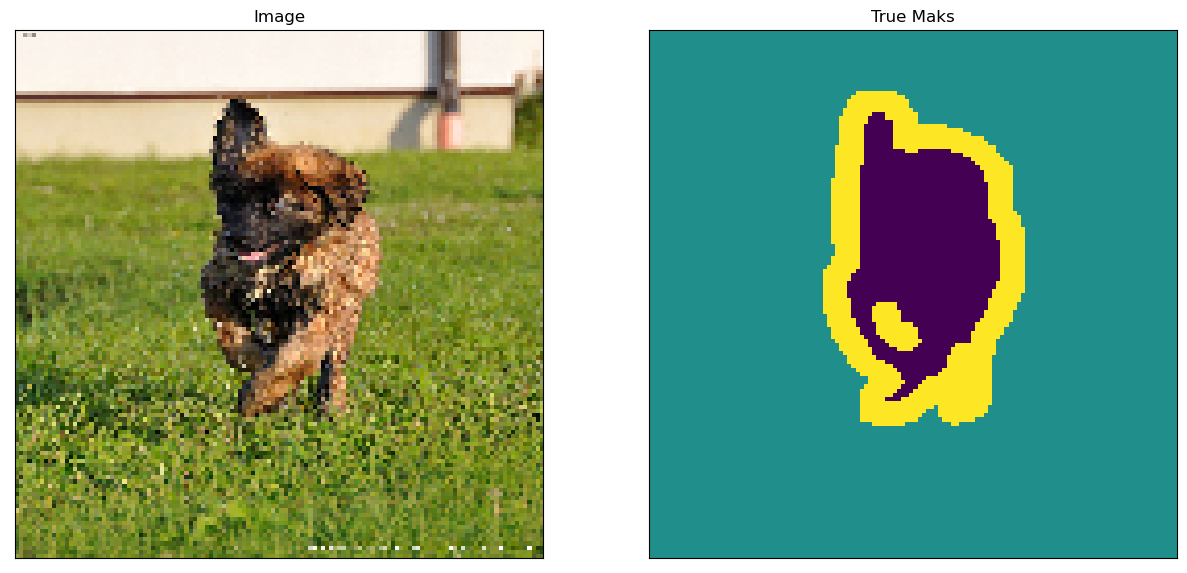

In [9]:
# train 셋의 이미지
show_image_from_dataset(train)
 
# test 셋의 이미지
show_image_from_dataset(test)

# Model

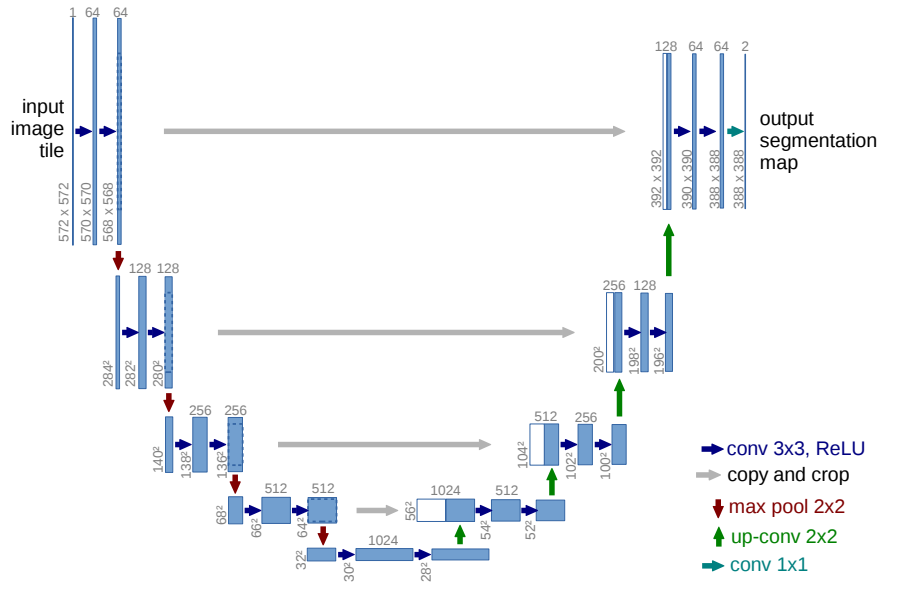

## Encoder
- 각 블록에서 Conv 연산은 두번씩 이루어집니다. 이를 블록형태로 구현.

In [10]:
# Encoder
 
def conv2d_block(input_tensor, n_filters, kernel_size=3):
    '''
    Conv layer 2개 추가 
    '''
 
    x = input_tensor
    for i in range(2):
        x = tf.keras.layers.Conv2D(filters=n_filters, kernel_size=kernel_size,
                                   kernel_initializer='he_normal', activation='relu', padding='same')(x)
    return x
 
def encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3):
    '''
    Conv layer 2개 추가한거 불러오고 maxpooling 및 dropout을 통해 downsampling
    '''
 
    f = conv2d_block(inputs, n_filters)
    p = tf.keras.layers.MaxPooling2D(pool_size=pool_size)(f)
    p = tf.keras.layers.Dropout(dropout)(p)
 
    return f, p # skip connection을 위한 conv layer의 output과, 다음 encoder block에서 사용될 output을 반환
 
def encoder(inputs):
    '''
    인코더 및 downsampling한 경로를 정의
    '''
    
    f1, p1 = encoder_block(inputs, n_filters=64)
    f2, p2 = encoder_block(p1, n_filters=128)
    f3, p3 = encoder_block(p2, n_filters=256)
    f4, p4 = encoder_block(p3, n_filters=512)
 
    return p4, (f1, f2, f3, f4)

**Encoder의 마지막 결과값을 decoder로 전달하기 전에 진행되는 bottleneck 정의**

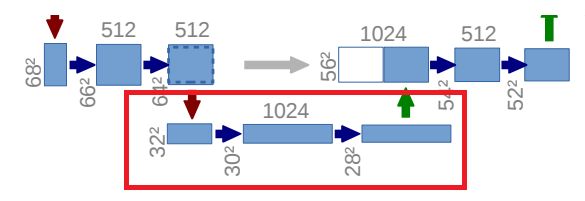

In [11]:
# Bottlenect
def bottleneck(inputs):
    bottle_neck = conv2d_block(inputs, n_filters=1024)
    return bottle_neck

## Decoder
- decoder_block에서는 input의 Conv2DTranspose를 통해 Upsampling을 진행하고, Encoder의 output과 concatenate를 진행한 후, Convolution을 두 번 수행합니다.

In [12]:
# Decoder
def decoder_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3):
    '''
    UNet의 하나의 디코더 블록을 정의
    '''
    # Conv2DTranspose -> 업샘플링, 디컨볼루션
    u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides, padding='same')(inputs) 
    c = tf.keras.layers.concatenate([u, conv_output])  # Encoder의 output과 concatenate
    c = tf.keras.layers.Dropout(dropout)(c)
    c = conv2d_block(c, n_filters)
 
    return c
 
def decoder(inputs, convs, output_channels):
    '''
    4개의 디코더 블록을 함께 연결하는 UNet의 디코더를 정의
    '''
 
    f1, f2, f3, f4 = convs
 
    c6 = decoder_block(inputs, f4, n_filters=512, kernel_size=3, strides=2)
    c7 = decoder_block(c6, f3, n_filters=256, kernel_size=3, strides=2)
    c8 = decoder_block(c7, f2, n_filters=128, kernel_size=3, strides=2)
    c9 = decoder_block(c8, f1, n_filters=64, kernel_size=3, strides=2)
 
    outputs = tf.keras.layers.Conv2D(output_channels, 1, activation='softmax')(c9)
 
    return outputs

**Encoder와 Decoder 연결해서 최종 UNet을 구성하는 함수 정의**

In [13]:
OUTPUT_CHANNELS = 3  # 분류해야되는 Pixel의 클래스(Pet,Outline,Background)
 
def UNet():
    '''
    Encoder, bottleneck, Decoder를 연결하여 UNet 정의
    '''
 
    inputs = tf.keras.layers.Input(shape=(128,128,3,))
 
    encoder_output, convs = encoder(inputs)
    bottle_neck = bottleneck(encoder_output)
    outputs = decoder(bottle_neck, convs, OUTPUT_CHANNELS)
 
    model = tf.keras.Model(inputs, outputs)
 
    return model
 
model = UNet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

**모델 compile 및 train**

In [14]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['acc'])

In [15]:
# 학습 매개변수 구성 및 모델 학습
TRAIN_LENGTH = info.splits['train'].num_examples
EPOCHS = 20
VAL_SUBSPLITS = 5
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS
 
model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset)

Epoch 1/20
57/57 [==============================] - 43s 577ms/step - loss: 0.8987 - acc: 0.5882 - val_loss: 0.8196 - val_acc: 0.5861
Epoch 2/20
57/57 [==============================] - 37s 570ms/step - loss: 0.7990 - acc: 0.6160 - val_loss: 0.7310 - val_acc: 0.6938
Epoch 3/20
57/57 [==============================] - 32s 561ms/step - loss: 0.6754 - acc: 0.7215 - val_loss: 0.6908 - val_acc: 0.7105
Epoch 4/20
57/57 [==============================] - 32s 561ms/step - loss: 0.6047 - acc: 0.7576 - val_loss: 0.5618 - val_acc: 0.7768
Epoch 5/20
57/57 [==============================] - 31s 553ms/step - loss: 0.5315 - acc: 0.7895 - val_loss: 0.5251 - val_acc: 0.7931
Epoch 6/20
57/57 [==============================] - 31s 550ms/step - loss: 0.4772 - acc: 0.8150 - val_loss: 0.4341 - val_acc: 0.8320
Epoch 7/20
57/57 [==============================] - 31s 547ms/step - loss: 0.4509 - acc: 0.8262 - val_loss: 0.4474 - val_acc: 0.8242
Epoch 8/20
57/57 [==============================] - 31s 548ms/step - 

**아래는 train loss와 validation loss의 그래프입니다.**

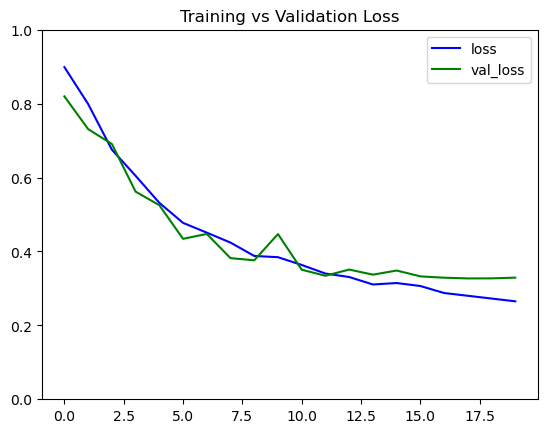

In [16]:
# Plot the training and validation loss
def plot_metrics(model_history, metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(model_history.history[metric_name], 'b', label=metric_name)
    plt.plot(model_history.history['val_' + metric_name], 'g', label='val_'+metric_name)
    plt.legend()
    
plot_metrics(model_history, "loss", title="Training vs Validation Loss", ylim=1)

# Prediction
- test 데이터에 적용 <br>

FCN에서 사용했던 IoU와 Dice Score 계산함수

In [17]:
# Prediction Utilities
def get_test_image_and_annotation_arrays():
    '''
    Unpacks the test dataset and returns the input images and segmentation masks
    '''
 
    ds = test_dataset.unbatch()
    ds = ds.batch(info.splits['test'].num_examples)
 
    images = []
    y_true_segments = []
 
    for image, annotation in ds.take(1):
        y_true_segments = annotation.numpy()
        images = image.numpy()
    
    y_true_segments = y_true_segments[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))]
 
    return images[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))], y_true_segments
 
def create_mask(pred_mask):
    '''
    Creates the segmentation mask by getting the channel with the highest probability. Remember that we
    have 3 channels in the output of the UNet. For each pixel, the predicition will be the channel with the
    highest probability.
    '''
 
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0].numpy()
 
def make_predictions(image, mask, num=1):
    '''
    Feeds an image to a model and returns the predicted mask
    '''
 
    image = np.reshape(image, (1, image.shape[0], image.shape[1], image.shape[2]))
    pred_mask = model.predict(image)
    pred_mask = create_mask(pred_mask)
 
    return pred_mask
    
def class_wise_metrics(y_true, y_pred):
    class_wise_iou = []
    class_wise_dice_score = []
 
    smoothening_factor = 0.00001
    
    for i in range(3):
        intersection = np.sum((y_pred==i) * (y_true==i))
        y_true_area = np.sum((y_true==i))
        y_pred_area = np.sum((y_pred==i))
        combined_area = y_true_area + y_pred_area
 
        iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
        class_wise_iou.append(iou)
 
        dice_score = 2 * ((intersection + smoothening_factor) / (combined_area + smoothening_factor))
        class_wise_dice_score.append(dice_score)
    
    return class_wise_iou, class_wise_dice_score

**test data의 ground truth 값과 predictions을 구하고, class별 metric(IoU, Dice Score)을 계산**

In [18]:
y_true_images, y_true_segments = get_test_image_and_annotation_arrays()
 
# feed the test set to th emodel to get the predicted masks
results = model.predict(test_dataset, steps=info.splits['test'].num_examples//BATCH_SIZE)
results = np.argmax(results, axis=3)
results = results[..., tf.newaxis]
 
# compute the class wise metrics
cls_wise_iou, cls_wise_dice_score = class_wise_metrics(y_true_segments, results)


**class별 IoU 결과**

In [19]:
# show the IOU for each class
for idx, iou in enumerate(cls_wise_iou):
    spaces = ' ' * (10-len(class_names[idx]) + 2)
    print("{}{}{} ".format(class_names[idx], spaces, iou)) 


pet         0.7760778788907456 
background  0.8737322906739252 
outline     0.41947307505133896 


**class별 Dice Score 결과**

In [20]:
# show the Dice Score for each class
for idx, dice_score in enumerate(cls_wise_dice_score):
    spaces = ' ' * (10-len(class_names[idx]) + 2)
    print("{}{}{} ".format(class_names[idx], spaces, dice_score))


pet         0.8739232531578566 
background  0.9326116596515447 
outline     0.5910264624589849 


**예측결과 시각화**

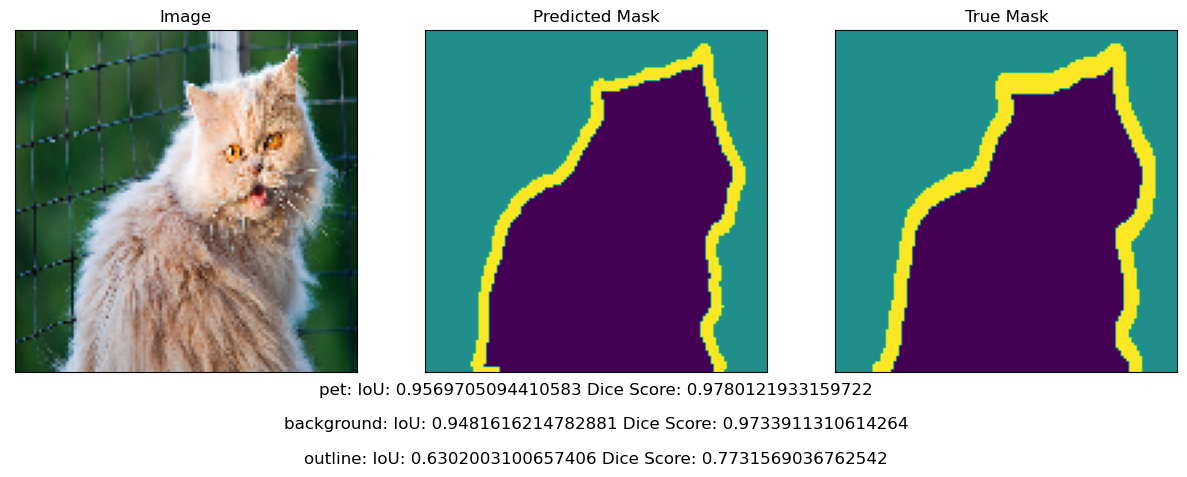

In [24]:
# 데이터 세트에서 이미지를 선택하려면 0에서 3647 사이의 숫자를 입력
integer_slider = 1601
 
# Get the prediction mask
y_pred_mask = make_predictions(y_true_images[integer_slider], y_true_segments[integer_slider])
 
# 클래스별 metric
iou, dice_score = class_wise_metrics(y_true_segments[integer_slider], y_pred_mask)  
 
# metricr과 이미지 오버레이
display_with_metrics([y_true_images[integer_slider], y_pred_mask, y_true_segments[integer_slider]], iou, dice_score)


FCN에 이어서 UNet 구조로 Segmentation을 진행해보았는데, 외곽선을 잘 잡아내는 모습이다!